In [1]:
import mne
import numpy as np
import pandas as pd

In [40]:
# Load the raw bdf file
raw = mne.io.read_raw_bdf('psyco dat/test_2.bdf')

# drop all channels except A16, A13, A32, A31, A7, A24
#raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','A12','A19','Status','EXG7','EXG8'])
raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','A12','A19','Status'])
rename_map = {
    'A16': 'Oz',
    'A13': 'Pz',
    'A32': 'Cz',
    'A31': 'Fz',
    'A24': 'T8',
    'A7': 'T7',
    'A12': 'P3',
    'A19': 'P4',
}

# Rename channels
raw.rename_channels(rename_map)



Extracting EDF parameters from c:\Users\tomje\Documents\GitHub\Visual-Acuity-P3\psyco dat\test_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | test_2.bdf, 9 x 9699328 (4736.0 s), ~12 KiB, data not loaded>

In [42]:
min_duration = (5) / raw.info['sfreq']
events = mne.find_events(raw, min_duration=min_duration)

# print unique event IDs
unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)

Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
14176 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65382 65383]
Unique event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65382 65383]


In [43]:
logical_triggers = [x & 0xFF for x in events[:, 2]]
logical_triggers = pd.Series(logical_triggers, name='Logical Triggers')
print(logical_triggers.value_counts())

# print sum count of each logical trigger below 100
print("Sum count of each logical trigger below 100:")
print(logical_triggers[logical_triggers < 100].value_counts().sum())


Logical Triggers
2      1386
7      1372
5      1332
1      1314
8      1298
9      1298
3      1274
6      1264
4      1247
103     834
101     725
16       98
19       96
13       92
11       89
14       83
15       81
17       76
18       75
10       59
12       58
102      25
Name: count, dtype: int64
Sum count of each logical trigger below 100:
12592


In [44]:
# re reference the data to average of T7 and T8
raw.load_data()  # Load the data into memory
raw.set_eeg_reference(ref_channels=['T7', 'T8'], projection=False)
#raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'], projection=False)
# decimate the data to 256Hz
#raw.resample(256, npad='auto')
# filter above 30Hz lowpass
raw.filter(None, 30, fir_design='firwin', skip_by_annotation='edge')
# Save the modified raw data to a new file
#raw.save('/psyco dat/test_2-raw.fif', overwrite=True)

Reading 0 ... 9699327  =      0.000 ...  4736.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 903 samples (0.441 s)



<RawEDF | test_2.bdf, 9 x 9699328 (4736.0 s), ~666.0 MiB, data loaded>

Number of events with logical event ID 19: 16
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.


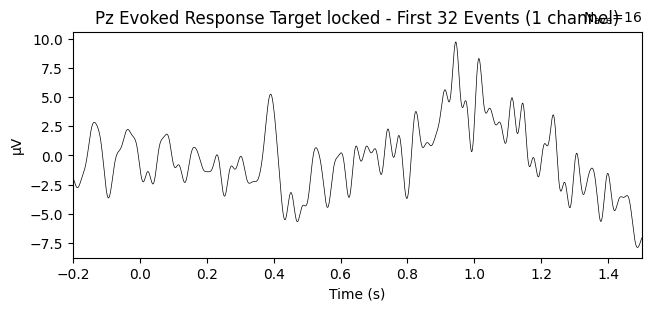

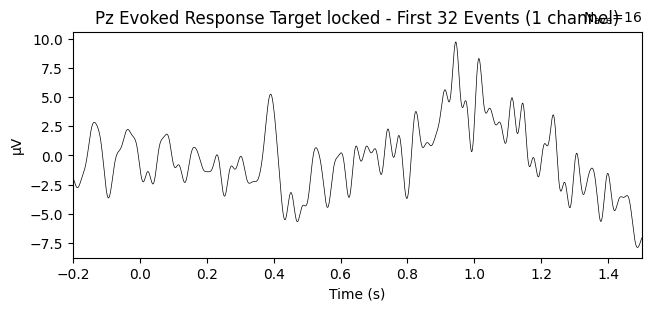

In [45]:
# Find indices of events with logical event ID 19
mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in events[:, 2]]
#mask = (events[:, 2] & 0xFF) == 101
events_19 = events[mask]
# only take first 32 events
events_19 = events_19[:16]

reject = dict(eeg=100e-6)  # Reject epochs with peak-to-peak amplitude > 100 µV

print(f"Number of events with logical event ID 19: {len(events_19)}")

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 1.5 
epochs = mne.Epochs(raw, events_19, tmin=tmin, tmax=tmax, baseline=(-0.2, 0),reject=None, detrend=1, preload=True)



# Get evoked response for Pz
evoked = epochs.average().pick('Pz')


# Plot the evoked response
evoked.plot(titles='Pz Evoked Response Target locked - First 32 Events')

In [50]:
#plot stimulus channel
stim_channel = raw.copy().pick('Erg1')
stim_channel.plot(title='Stimulus Channel - Status', duration=1)

ValueError: picks ('Erg1') could not be interpreted as channel names (no channel "[np.str_('Erg1')]"), channel types (no type "Erg1" present), or a generic type (just "all" or "data")

Number of events with logical event ID 19: 1
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.


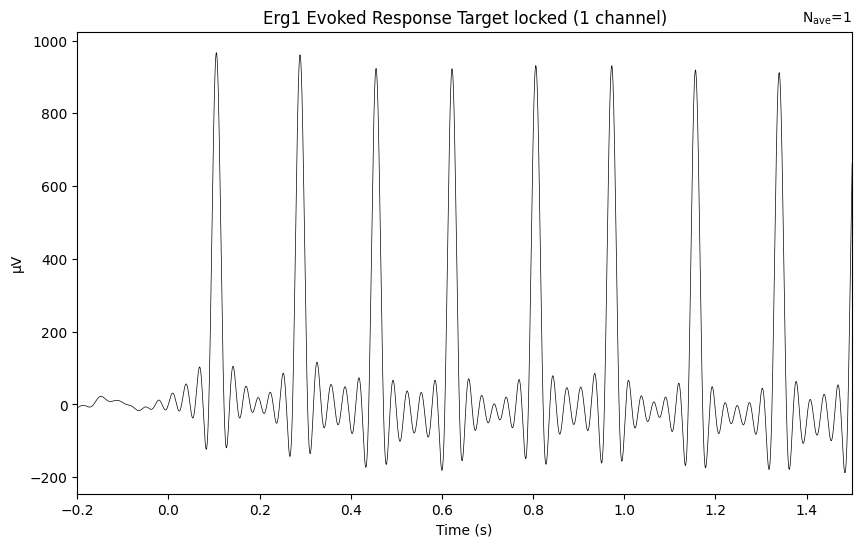

<Figure size 640x480 with 0 Axes>

In [ ]:

# Find indices of events with logical event ID 19
#mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in events[:, 2]]
mask = (events[:, 2] & 0xFF) == 101
events_19 = events[mask]
# only take first 32 events
events_19 = events_19[:1]

reject = dict(eeg=10000e-6)  # Reject epochs with peak-to-peak amplitude > 100 µV

print(f"Number of events with logical event ID 19: {len(events_19)}")

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 1.5 
epochs = mne.Epochs(raw, events_19, tmin=tmin, tmax=tmax, baseline=(-0.2, 0),reject=None, detrend=1, preload=True)



# Get evoked response for Pz
evoked = epochs.average().pick('Erg1')

import matplotlib.pyplot as plt

# Plot the evoked response
fig, ax = plt.subplots(figsize=(10, 6))
evoked.plot(axes=ax, titles='Erg1 Evoked Response Target locked')

# Calculate time offset relative to the epoch start
# Since tmin is -0.2, we need to adjust the event time to be relative to this epoch
for event in events:
    # Mark time 0 (event trigger time) with a vertical line
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Event Trigger')
    
# Add legend (only once)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()


looks like the markers are off compared to photodiode. spike should be at 0 time

4454
Length of stimulus channel: 2695168
Number of events in the stimulus channel: 690831


<Axes: title={'center': 'Stimulus Channel - First 1000 Samples'}>

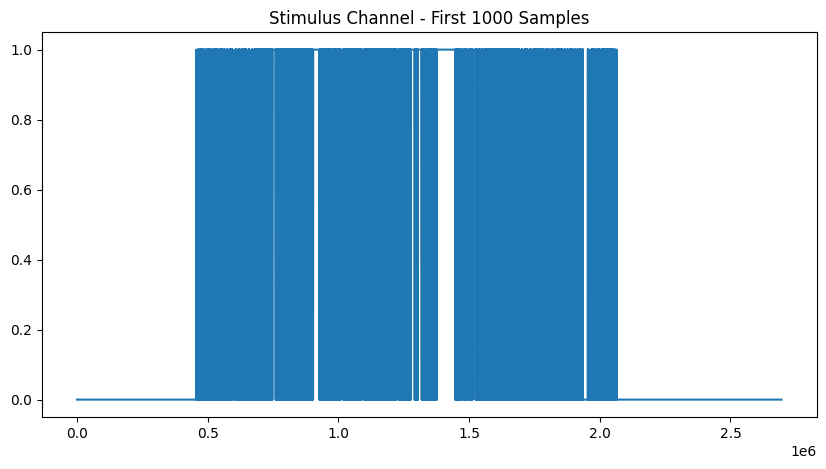

In [ ]:
# need to get the event markers from the signal as a series
event_markers = pd.Series(events[:, 2], name='Event Markers')
# Convert event markers to logical triggers
logical_triggers = event_markers.apply(lambda x: x & 0xFF)
# Plot the logical triggers
print(len(logical_triggers))
# print l;ength of stimulus channel
stim_channel = raw.copy().pick('Erg1')
print(f"Length of stimulus channel: {len(stim_channel)}")


# events[:, 0] = time in seconds
# events[:, 2] = event ID
# create time series of event markers with length of stimulus channel, 0 for no event, marker code for event
event_series = pd.Series(0, index=np.arange(len(stim_channel.times)), name='Event Markers')
# Fill in the event markers at the corresponding times
for event in events:
    time_index = int(event[0])  # Convert time to index
    if time_index < len(event_series):
        event_series.iloc[time_index] = event[2] & 0xFF  # Store the logical trigger


# stimulus channel needs detrending to remove DC offset
stim_channel._data[0] = mne.filter.detrend(stim_channel._data[0])


# new stimulus channel, 0 for no event, 1 for event, event is defined sith stimulus channel greater than 200 uV
stimulus_channel = pd.Series(0, index=np.arange(len(stim_channel.times)), name='Stimulus Channel')
# Fill in the stimulus channel where the event markers are greater than 200 uV
stimulus_channel[stim_channel._data[0] > 600e-6] = 1  # Assuming the first channel is the stimulus channel

# print number of events in the stimulus channel
print(f"Number of events in the stimulus channel: {stimulus_channel.sum()}")

# plot 1000 samples of the stimulus channel from sample 1000 to 2000
stimulus_channel.plot(title='Stimulus Channel - First 1000 Samples', figsize=(10, 5))



In [ ]:
stim_channel.filter(l_freq=0.5, h_freq=None, fir_design='firwin')

# Now, get the filtered data as a numpy array
filtered_data = stim_channel.get_data()[0]



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 13517 samples (6.600 s)



In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import detrend

# Detrend the signal to remove DC drift
signal = detrend(stim_channel._data[0])

# Parameters
threshold = 600e-6  # 600 µV threshold
refractory_period = int(0.119 * 2048)  # 120 ms in samples
stimulus_channel = np.zeros_like(signal)

above_threshold = signal > threshold
i = 0
while i < len(signal):
    if above_threshold[i]:
        # Trigger found
        stimulus_channel[i] = 1

        # Skip ahead by refractory period to avoid multiple detections
        i += refractory_period
    else:
        i += 1

# Optionally wrap in a pandas Series
stimulus_channel = pd.Series(stimulus_channel, name='Stimulus Channel')
print(f"Number of triggers detected: {stimulus_channel.sum()}")

# plot event markers
event_markers_values = event_series.to_numpy()
stimulus_channel_values = stimulus_channel.to_numpy()
# print length of event markers and stimulus channel
print(f"Length of event markers: {len(event_markers_values)}")
print(f"Length of stimulus channel: {len(stimulus_channel_values)}")
# print first 20 samples of event markers and stimulus channel
print("First 20 samples of event markers:", event_markers_values[200000:200010])
print("First 20 samples of stimulus channel:", stimulus_channel_values[200000:200010])


Number of triggers detected: 3939.0
Length of event markers: 2695168
Length of stimulus channel: 2695168
First 20 samples of event markers: [0 0 0 0 0 0 0 0 0 0]
First 20 samples of stimulus channel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import numpy as np
from scipy.spatial import cKDTree

# Step 1: Get indices where things happen
event_indices = np.where((event_markers_values >= 1) & (event_markers_values <= 19))[0]
photodiode_indices = np.where(stimulus_channel_values == 1)[0]

print(f"Number of event markers: {len(event_indices)}")
print(f"Number of photodiode peaks: {len(photodiode_indices)}")

# Step 2: Use KDTree for efficient nearest-neighbor matching
# This allows us to find the closest photodiode index to each event
tree = cKDTree(photodiode_indices[:, np.newaxis])
distances, matched_pd_idx = tree.query(event_indices[:, np.newaxis], k=1)

# Step 3: Build a list of matched pairs (event_index, photodiode_index, event_code)
matched_pairs = []
used_pd_indices = set()

for i, (evt_idx, pd_idx, dist) in enumerate(zip(event_indices, photodiode_indices[matched_pd_idx], distances)):
    # Make sure we don't reuse the same photodiode peak
    if pd_idx in used_pd_indices:
        continue
    matched_pairs.append((evt_idx, pd_idx, event_markers_values[evt_idx]))
    used_pd_indices.add(pd_idx)

print(f"Successfully matched {len(matched_pairs)} events to photodiode peaks")

# Optional: turn into a DataFrame
import pandas as pd
matched_df = pd.DataFrame(matched_pairs, columns=['event_index', 'photodiode_index', 'event_code'])


Number of event markers: 3933
Number of photodiode peaks: 3939
Successfully matched 3678 events to photodiode peaks


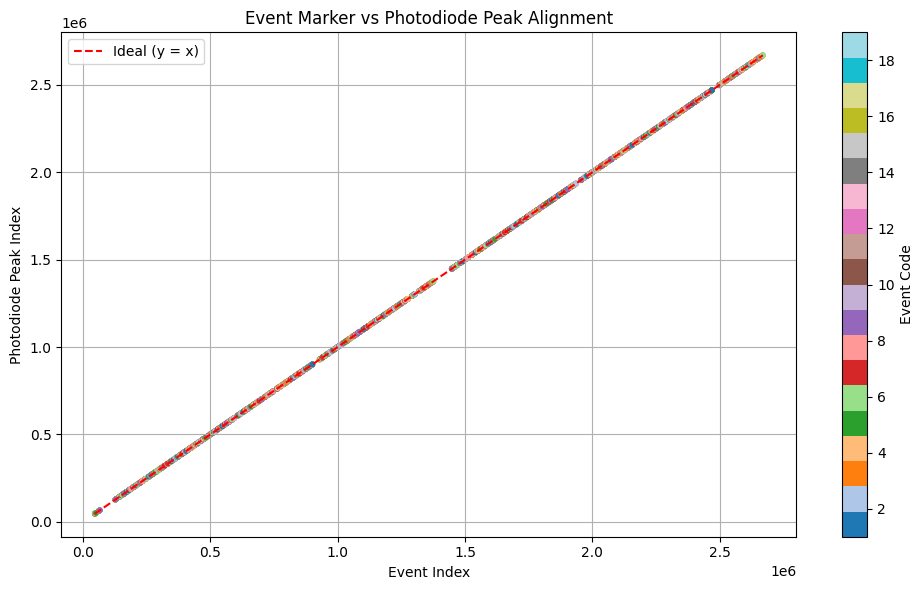

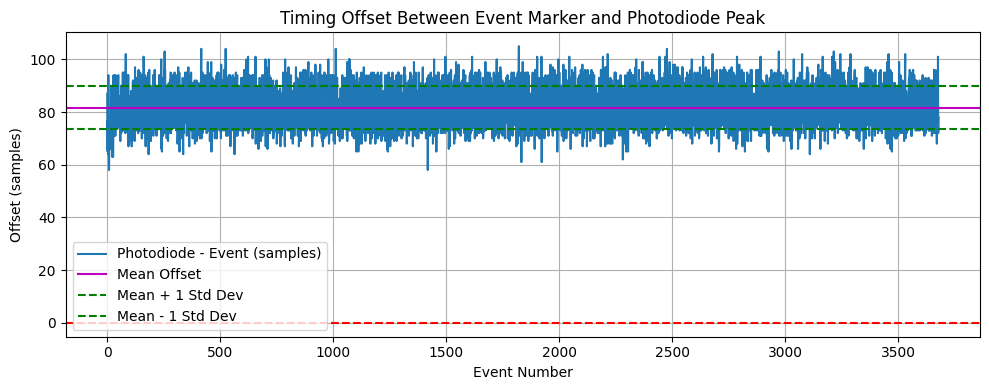

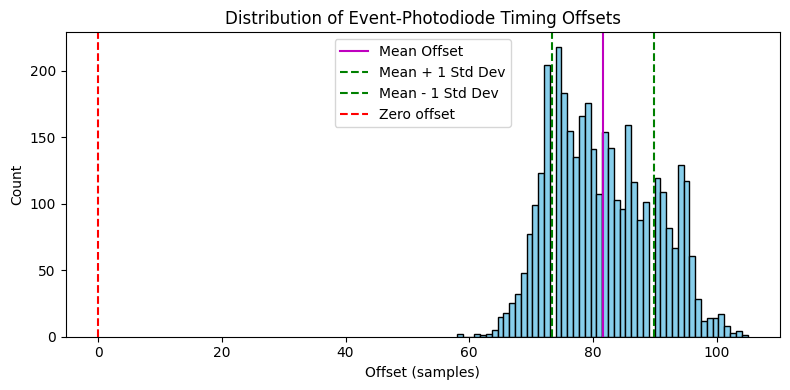

Mean Offset: 81.65769439912997 samples
Standard Deviation of Offsets: 8.262417735270416 samples


In [ ]:
import matplotlib.pyplot as plt

# Convert matched pairs to arrays
event_idx_arr = matched_df['event_index'].to_numpy()
photodiode_idx_arr = matched_df['photodiode_index'].to_numpy()
event_code_arr = matched_df['event_code'].to_numpy()

# 1. Scatter plot of raw indices
plt.figure(figsize=(10, 6))
plt.scatter(event_idx_arr, photodiode_idx_arr, c=event_code_arr, cmap='tab20', s=10)
plt.plot([event_idx_arr.min(), event_idx_arr.max()], [event_idx_arr.min(), event_idx_arr.max()], 'r--', label='Ideal (y = x)')
plt.xlabel('Event Index')
plt.ylabel('Photodiode Peak Index')
plt.title('Event Marker vs Photodiode Peak Alignment')
plt.colorbar(label='Event Code')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Difference plot
offsets = photodiode_idx_arr - event_idx_arr  # in samples

plt.figure(figsize=(10, 4))
plt.plot(offsets, label='Photodiode - Event (samples)')
# plot mean and standard deviation lines
plt.axhline(np.mean(offsets), color='m', linestyle='-', label='Mean Offset')
plt.axhline(np.mean(offsets) + np.std(offsets), color='g', linestyle='--', label='Mean + 1 Std Dev')
plt.axhline(np.mean(offsets) - np.std(offsets), color='g', linestyle='--', label='Mean - 1 Std Dev')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Event Number')
plt.ylabel('Offset (samples)')
plt.title('Timing Offset Between Event Marker and Photodiode Peak')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram of time offsets
plt.figure(figsize=(8, 4))
plt.hist(offsets, bins=50, color='skyblue', edgecolor='k')
# Add mean and std dev lines
plt.axvline(np.mean(offsets), color='m', linestyle='-', label='Mean Offset')
plt.axvline(np.mean(offsets) + np.std(offsets), color='g', linestyle='--', label='Mean + 1 Std Dev')
plt.axvline(np.mean(offsets) - np.std(offsets), color='g', linestyle='--', label='Mean - 1 Std Dev')
plt.axvline(0, color='red', linestyle='--', label='Zero offset')
plt.xlabel('Offset (samples)')
plt.ylabel('Count')
plt.title('Distribution of Event-Photodiode Timing Offsets')
plt.legend()
plt.tight_layout()
plt.show()


# print mean and standard deviation of offsets
mean_offset = np.mean(offsets)
std_offset = np.std(offsets)
print(f"Mean Offset: {mean_offset} samples")
print(f"Standard Deviation of Offsets: {std_offset} samples")

Number of events with logical event ID 19: 32
Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.


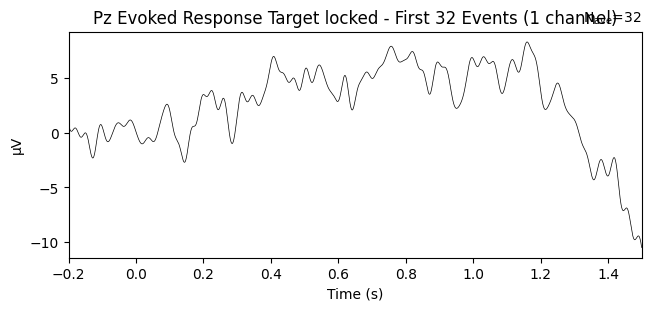

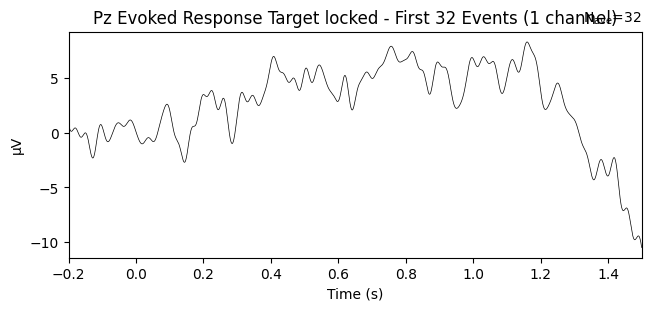

In [ ]:
# update events with the matched photodiode indices using dataframe
new_events = events.copy()
for i, event in enumerate(new_events):
    # Find matching row in matched_df
    match = matched_df[matched_df['event_index'] == event[0]]
    if not match.empty:
        # Update the sample index (first column) with the photodiode index
        new_events[i, 0] = match.iloc[0]['photodiode_index']

# Find indices of events with logical event ID 19
mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in new_events[:, 2]]
#mask = (events[:, 2] & 0xFF) == 101
events_19 = new_events[mask]
# only take first 32 events
events_19 = events_19[:32]

reject = dict(eeg=100e-6)  # Reject epochs with peak-to-peak amplitude > 100 µV

print(f"Number of events with logical event ID 19: {len(events_19)}")

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 1.5 
epochs = mne.Epochs(raw, events_19, tmin=tmin, tmax=tmax, baseline=(-0.2, 0), detrend=1, preload=True)



# Get evoked response for Pz
evoked = epochs.average().pick('Pz')


# Plot the evoked response
evoked.plot(titles='Pz Evoked Response Target locked - First 32 Events')

Number of events with logical event ID 19: 260
Number of complete groups of 16: 16
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 3483 original time points ...
0 bad epochs dropped
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 3483 original time points ...
0 bad epochs dropped
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 3483 original time points ...
0 bad epochs dropped
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 3483 original time points ...
0 bad epochs dropped
Not setting metadata
16 matching events found
Applyin

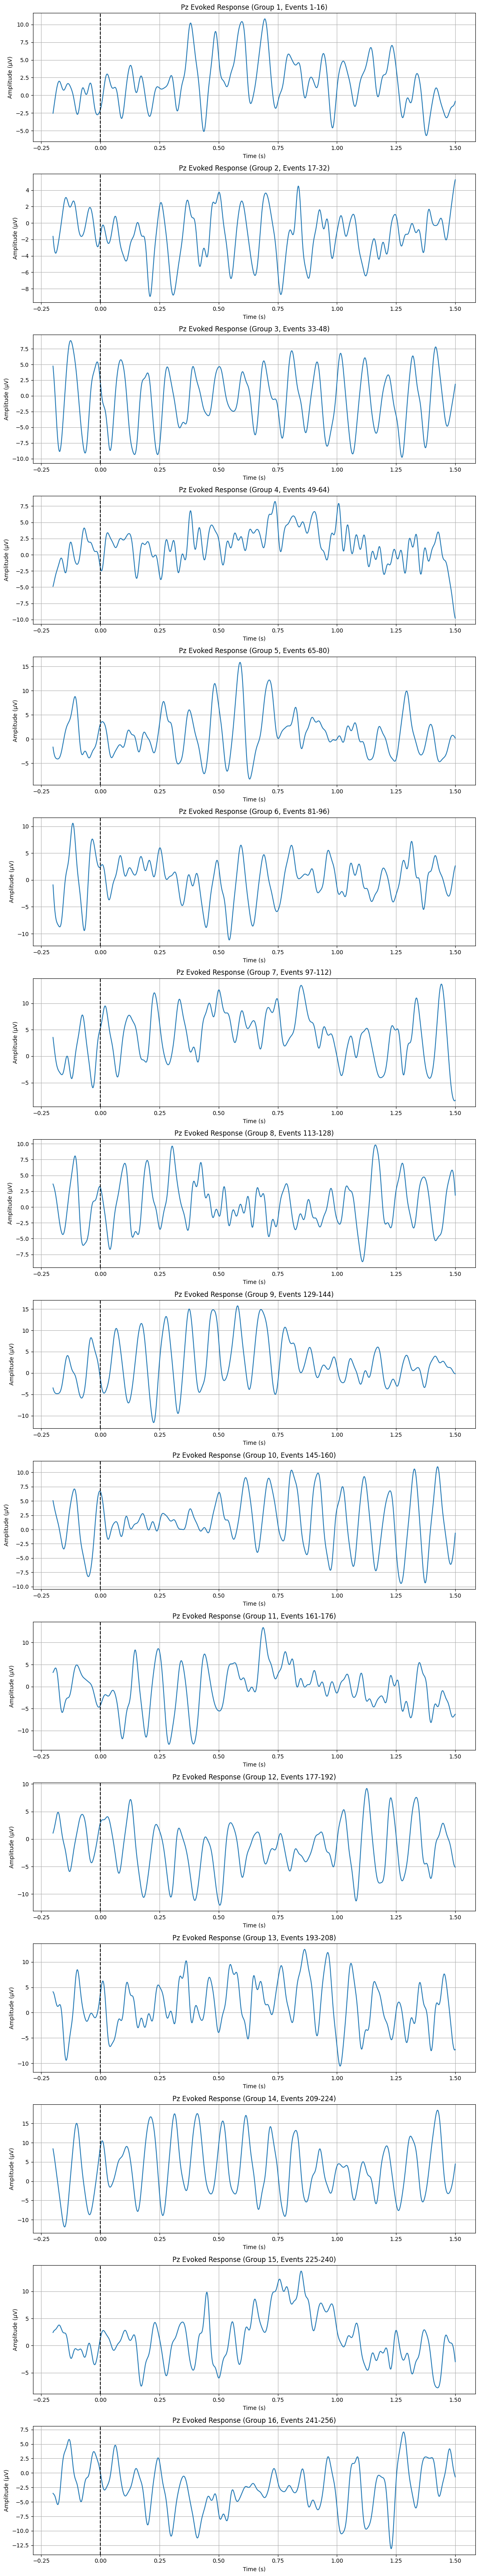

In [52]:
import matplotlib.pyplot as plt

# Find indices of events with logical event ID 19
mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in events[:, 2]]
#mask = (events[:, 2] & 0xFF) == 101
events_19 = events[mask]
# only take first 32 events
#events_19 = events_19[:16]

# Calculate how many complete groups of 16 we have
num_events = len(events_19)
num_groups = num_events // 16
print(f"Number of events with logical event ID 19: {num_events}")
print(f"Number of complete groups of 16: {num_groups}")

# Create a figure with the correct number of subplots
fig, axes = plt.subplots(nrows=num_groups, figsize=(12, 4 * num_groups), squeeze=False)

# Epoch parameters
tmin = -0.2
tmax = 1.5

# Loop through each group of 16 events
for i in range(num_groups):
    start_idx = i * 16
    end_idx = (i + 1) * 16
    group_events = events_19[start_idx:end_idx]
    
    epochs = mne.Epochs(raw, group_events, tmin=tmin, tmax=tmax, 
                        baseline=(-0.2, 0), reject=None, 
                        detrend=1, preload=True)
    
    # Get evoked response for Pz
    evoked = epochs.average().pick('Pz')
    
    # Manually plot the evoked data onto the given axis
    ax = axes[i, 0]
    times = evoked.times
    data = evoked.data[0]  # Only one channel ('Pz') after picking
    ax.plot(times, data * 1e6)  # Convert to µV if necessary
    ax.set_title(f'Pz Evoked Response (Group {i+1}, Events {start_idx+1}-{end_idx})')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.axvline(0, color='k', linestyle='--')  # Mark stimulus onset
    ax.grid(True)

plt.tight_layout()
plt.show()


In [26]:
csv = 'psyco dat\participant_test3_50cm_20250605_123922_1.csv'
# Load the CSV file
df = pd.read_csv(csv)
# drop all columns except 'letter_accuracy', 'block_type'
df = df[['letter_accuracy', 'block_type','letter_response']]

raw = mne.io.read_raw_bdf('psyco dat/test_arpan_2_20cm.bdf')

# drop all channels except A16, A13, A32, A31, A7, A24
#raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','A12','A19','Status','EXG7','EXG8'])
raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','A12','A19','Status'])
rename_map = {
    'A16': 'Oz',
    'A13': 'Pz',
    'A32': 'Cz',
    'A31': 'Fz',
    'A24': 'T8',
    'A7': 'T7',
    'A12': 'P3',
    'A19': 'P4',
}

# Rename channels
raw.rename_channels(rename_map)
raw.load_data()  # Load the data into memory
raw.set_eeg_reference(ref_channels=['T7', 'T8'], projection=False)
#raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'], projection=False)
# decimate the data to 256Hz
#raw.resample(256, npad='auto')
# filter above 30Hz lowpass
raw.filter(0.1, 30, fir_design='firwin', skip_by_annotation='edge')

Extracting EDF parameters from c:\Users\tomje\Documents\GitHub\Visual-Acuity-P3\psyco dat\test_arpan_2_20cm.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 2695167  =      0.000 ...  1316.000 secs...


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\tomje\AppData\Local\Temp\ipykernel_51636\3735502097.py:1: SyntaxWarning: invalid escape sequence '\p'
  csv = 'psyco dat\participant_test3_50cm_20250605_123922_1.csv'


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 67585 samples (33.000 s)



<RawEDF | test_arpan_2_20cm.bdf, 9 x 2695168 (1316.0 s), ~185.1 MiB, data loaded>

In [27]:
# need to match events to the CSV file. there is equal number of target events and rows in the CSV file
# need to split the events into correct and incorrect based on the 'letter_accuracy' column
# then plot the evoked response for each condition

# Get the events from the raw data
min_duration = (80) / raw.info['sfreq']
events = mne.find_events(raw, min_duration=min_duration)

# print unique event IDs
unique_event_ids = np.unique(events[:, 2])
logical_triggers = [x & 0xFF for x in events[:, 2]]
logical_triggers = pd.Series(logical_triggers, name='Logical Triggers')


correct_events = []
incorrect_events = []

# Iterate through the DataFrame and match events
# Find events with logical triggers between 9 and 100 (target events), 102 is also a target event
target_mask = (logical_triggers > 9) & (logical_triggers < 100)
# Include logical trigger 102 as a target event
#target_mask |= (logical_triggers == 102)

target_events = events[target_mask]

# Skip the first two events (as instructed)
target_events = target_events[2:]
df = df.iloc[2:]  # Skip the first two rows in the DataFrame

# Check if we have enough events to match with df
print(f"Number of target events: {len(target_events)}")
print(f"Number of rows in df: {len(df)}")



Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)


4451 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65383]
Number of target events: 260
Number of rows in df: 260


Using 260 events for analysis
Number of correct events: 130
Number of incorrect events: 0


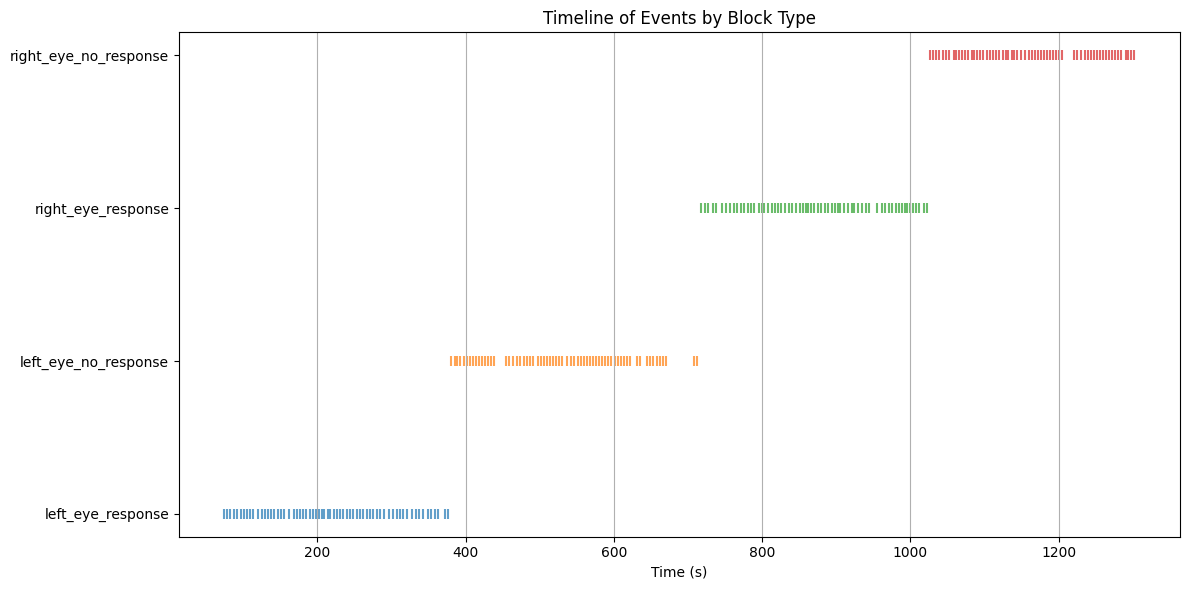

In [28]:
import matplotlib.pyplot as plt


n_events = min(len(target_events), len(df))
print(f"Using {n_events} events for analysis")

correct_events = []
incorrect_events = []

for i in range(n_events):
    event = target_events[i]
    # Check if this row in df has a valid letter_accuracy value
    if i < len(df) and not pd.isna(df.iloc[i]['letter_accuracy']):
        if df.iloc[i]['letter_response'] == 'l':
            incorrect_events.append(event)
        else:
            correct_events.append(event)

# Convert lists to numpy arrays
correct_events = np.array(correct_events)
incorrect_events = np.array(incorrect_events)

print(f"Number of correct events: {len(correct_events)}")
print(f"Number of incorrect events: {len(incorrect_events)}")

# Plot events on a timeline by block type
block_types = df['block_type'].unique()
plt.figure(figsize=(12, 6))

for i, block in enumerate(block_types):
    # Get indices where block_type matches
    block_indices = df[df['block_type'] == block].index
    
    # Find events corresponding to these indices
    block_events = [target_events[idx] for idx in block_indices if idx < len(target_events)]
    
    if block_events:
        # Extract times (in samples)
        event_times = [event[0] for event in block_events]
        # Convert to seconds
        event_times_sec = [t / raw.info['sfreq'] for t in event_times]
        
        # Plot with jittered y-position
        plt.scatter(event_times_sec, [i] * len(event_times_sec), 
                   label=block, alpha=0.7, marker='|', s=50)

plt.yticks(range(len(block_types)), block_types)
plt.xlabel('Time (s)')
plt.title('Timeline of Events by Block Type')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()



left_eye_response: 54 correct events, 11 incorrect events
Not setting metadata
54 matching events found


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 54 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.
right_eye_response: 55 correct events, 10 incorrect events
Not setting metadata
55 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 55 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projectio

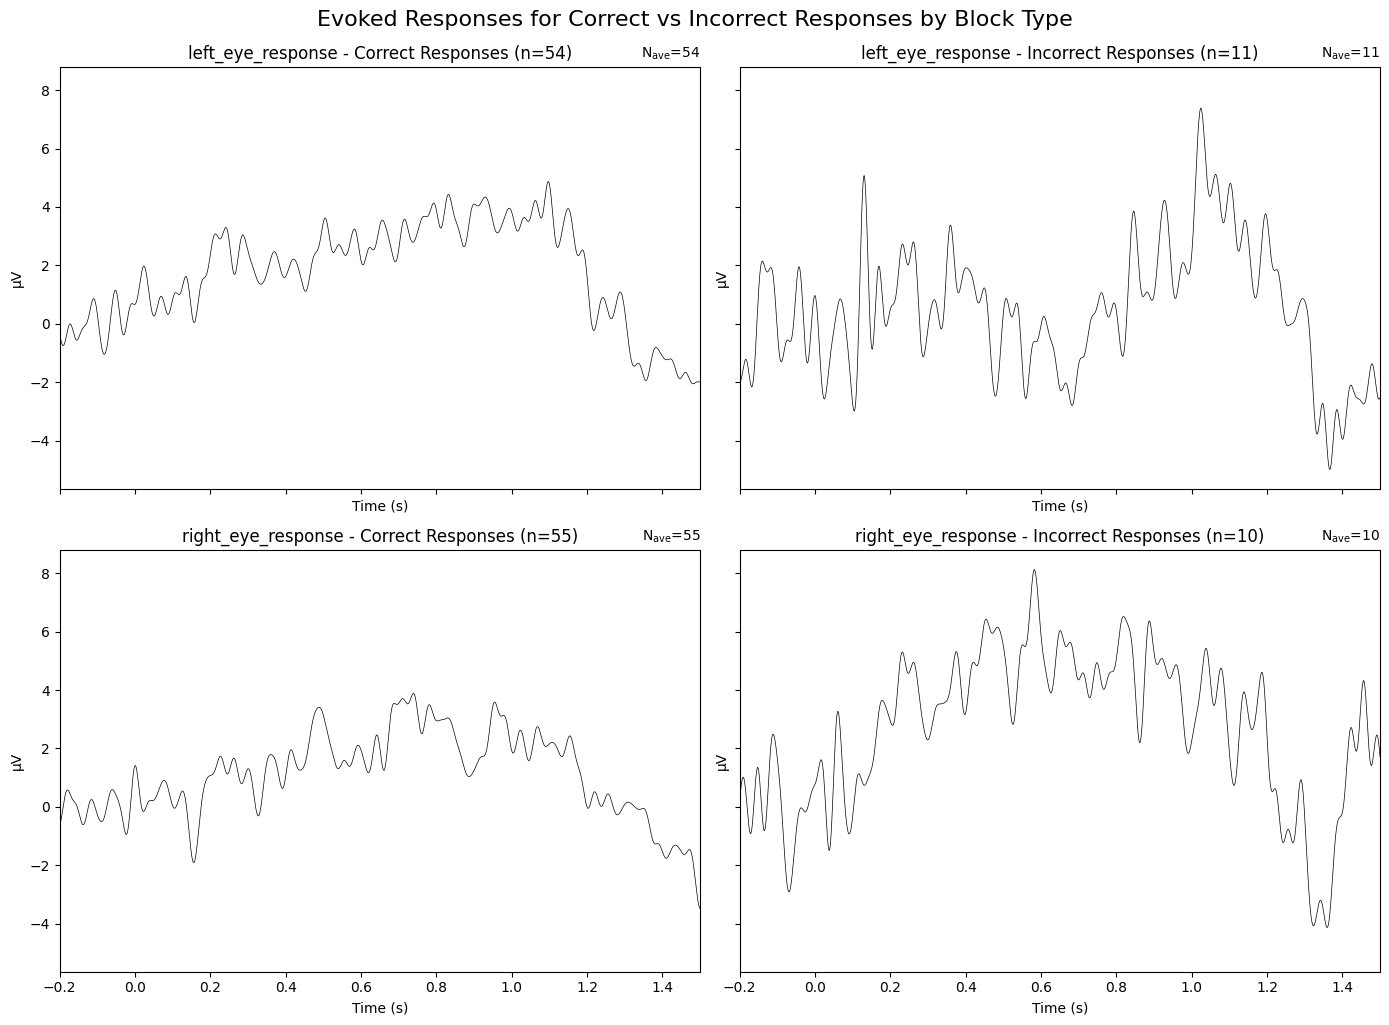

In [29]:
import matplotlib.pyplot as plt

# Define response blocks
response_blocks = ['left_eye_response', 'right_eye_response']

# Create a 2x2 grid of plots (rows: blocks, columns: correct/incorrect)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 1.5

for i, block in enumerate(response_blocks):
    # Get events for this block
    block_df = df[df['block_type'] == block]
    
    # Separate correct and incorrect events for this block
    correct_block_events = []
    incorrect_block_events = []
    
    for idx, row in block_df.iterrows():
        if idx < len(target_events):
            if not pd.isna(row['letter_accuracy']):
                if row['letter_accuracy'] == 1.0:
                    correct_block_events.append(target_events[idx])
                else:
                    incorrect_block_events.append(target_events[idx])
    
    # Convert to numpy arrays
    correct_block_events = np.array(correct_block_events)
    incorrect_block_events = np.array(incorrect_block_events)
    
    print(f"{block}: {len(correct_block_events)} correct events, {len(incorrect_block_events)} incorrect events")
    
    # Process correct events
    if len(correct_block_events) > 0:
        epochs = mne.Epochs(raw, correct_block_events, tmin=tmin, tmax=tmax, 
                          baseline=(-0.2, 0), reject=None, detrend=1, preload=True)
        evoked = epochs.average().pick('Pz')
        evoked.plot(axes=axes[i, 0], show=False)
        axes[i, 0].set_title(f'{block} - Correct Responses (n={len(correct_block_events)})')
    else:
        axes[i, 0].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i, 0].transAxes)
    
    # Process incorrect events
    if len(incorrect_block_events) > 0:
        epochs = mne.Epochs(raw, incorrect_block_events, tmin=tmin, tmax=tmax, 
                          baseline=(-0.2, 0), reject=None, detrend=1, preload=True)
        evoked = epochs.average().pick('Pz')
        evoked.plot(axes=axes[i, 1], show=False)
        axes[i, 1].set_title(f'{block} - Incorrect Responses (n={len(incorrect_block_events)})')
    else:
        axes[i, 1].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i, 1].transAxes)

plt.tight_layout()
plt.suptitle('Evoked Responses for Correct vs Incorrect Responses by Block Type', y=1.02, fontsize=16)
plt.show()
